In [ ]:
import itertools
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
warnings.simplefilter("ignore")

In [ ]:
# Loading the data
data_full = pd.read_csv('BasicCompanyDataAsOneFile-2021-11-01.csv')

In [ ]:
# Inspecting the data
print(data_full.describe())
print('----------------------')
print(data_full.info())

In [ ]:
# Taking the columns of interest
data = data_full[data_full.columns[:-25]].copy()
data = data.drop(list(data.columns[15:-4]), axis=1)

In [ ]:
# Inspecting the data
print(data.info())

In [ ]:
# Checking the content of each column
for i in data.columns:
    print(i, data[i].unique())
    print('-------------------')

In [ ]:
# Ceating digit SIC codes
data.loc[:, 'Sector_1'] = data['SICCode.SicText_1'].str[0:2]

In [ ]:
# Taking only the UK based companies
UKdata = data[(data['RegAddress.Country']== 'UNITED KINGDOM') | (data['RegAddress.Country']== 'ENGLAND')
              | (data['RegAddress.Country']=='SCOTLAND') | (data['RegAddress.Country']=='WALES')
              |(data['RegAddress.Country']=='NORTHERN IRELAND')| (data['RegAddress.Country']=='LIVERPOOL')
              | (data['RegAddress.Country']=='NORTHERN IRELAND UNITED KINGDOM')|
              (data['RegAddress.Country']=='BRITISH ISLES') |(data['RegAddress.Country']=='BRITISH CHANNEL ISLANDS')
              | (data['RegAddress.Country']=='ENGLAND & WALES') | (data['RegAddress.Country']=='SCOTLAND  UK')]

In [ ]:
# Converting Incorporation Date into datetime format
UKdata['Incorporation_New'] = UKdata.apply(lambda x: datetime.strptime(x['IncorporationDate'], '%d/%m/%Y'),axis=1)

In [ ]:
# Creating New columns from day, month, year
UKdata['Incorporation_Day'] = pd.DatetimeIndex(UKdata['Incorporation_New']).day
UKdata['Incorporation_Month'] = pd.DatetimeIndex(UKdata['Incorporation_New']).month
UKdata['Incorporation_Year'] = pd.DatetimeIndex(UKdata['Incorporation_New']).year

In [ ]:
UKdata

In [ ]:
# Checking and dropping empty dissolution date 
UKdata['DissolutionDate'].unique()
UKdata.drop('DissolutionDate', axis=1, inplace=True)

# First Graph

In [ ]:
UKdata1 = UKdata[UKdata['Incorporation_Year']>2015]

In [ ]:
UKdata1['CompanyCategory'].value_counts()

In [ ]:
# Grouping the categories 
UKdata1['CompanyCategory'].replace({'Private Unlimited Company': 'Other company type',
                                 'Private Unlimited': 'Other company type', 'United Kingdom Economic Interest Grouping' : 'Other company type',
                                 'Scottish Partnership' : 'Other company type','United Kingdom Societas' : 'Other company type'},
                               inplace=True)

In [ ]:
UKdata1['CompanyCategory'].unique()

In [ ]:
UKdata1.loc[:, 'CompanyCategory_Count'] = UKdata1['CompanyCategory']

In [ ]:
# Calcurating the number companies founded in each category per month
df = pd.DataFrame(UKdata1.groupby(['Incorporation_Year','Incorporation_Month'], as_index=False)['CompanyName'].aggregate(np.count_nonzero))

In [ ]:
df2 = df[df['Incorporation_Year']>2017]

In [ ]:
# Separating the data frame into 2018-2019 for comparisons
df18_19=df2[df2['Incorporation_Year']<2020]
df18_19 = df18_19.drop([46,47], axis=0)
df18_19.loc[:,'Index'] = range(1,23)
df18_19.set_index('Index', inplace=True)

In [ ]:
# Separating the data frame into 2020-2021 for comparisons
df20_21=df2[df2['Incorporation_Year']>=2020]
df20_21.loc[:,'Index'] = range(1,23)
df20_21.set_index('Index', inplace=True)

In [ ]:
df_plot = df2[['Incorporation_Year','Incorporation_Month']]

In [ ]:
df3 = pd.DataFrame(UKdata1.groupby(['Incorporation_Year','Incorporation_Month', 'CompanyCategory'], as_index=False)['CompanyCategory_Count'].aggregate(np.count_nonzero))

In [ ]:
df3 = df3[df3['Incorporation_Year']>2017]
df3

In [ ]:
for cat in df3['CompanyCategory'].unique():
    temp= df3.loc[df3['CompanyCategory']== cat,'CompanyCategory_Count'].values
    if cat == 'Other company type':
        temp = list(temp)
        temp.insert(30,0)
        temp.insert(39,0)
    df_plot.loc[:, cat] = temp

In [ ]:
df18_19_3=df_plot[df_plot['Incorporation_Year']<2020]
df18_19_3 = df18_19_3.drop([46,47], axis=0)
df18_19_3.loc[:,'Index'] = range(1,23)
df18_19_3.set_index('Index', inplace=True)

df20_21_3=df_plot[df_plot['Incorporation_Year']>=2020]
df20_21_3.loc[:,'Index'] = range(1,23)
df20_21_3.set_index('Index', inplace=True)

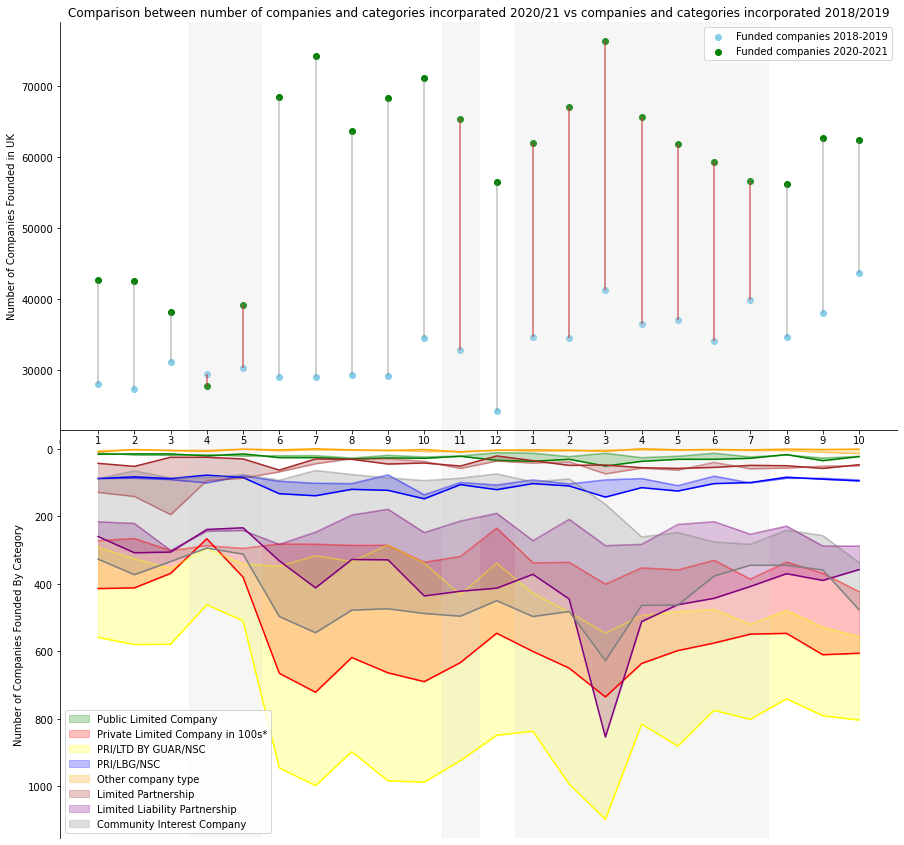

In [56]:
# Reorder it following the values of the first value:
my_range=range(1,len(df20_21.index)+1)
 
fig = plt.figure(figsize=(15,15))
ax1= fig.add_subplot(2,1,1)
ax= fig.add_subplot(2,1,2)

outer_grid = fig.add_gridspec(2, 1, wspace=0, hspace=0)

# Creating scatter plot
ax1.vlines(x=my_range, ymin=df18_19['CompanyName'], ymax=df20_21['CompanyName'], color='grey', alpha=0.5)
for i in [4,5,11,13,14,15,16,17,18,19]:
    ax1.vlines(x=i, ymin=df18_19['CompanyName'][i], ymax=df20_21['CompanyName'][i], color='red', alpha=0.4)
ax1.scatter(my_range,df18_19['CompanyName'], color='skyblue', alpha=1, label='Funded companies 2018-2019')
ax1.scatter(my_range,df20_21['CompanyName'], color='green', alpha=1 , label='Funded companies 2020-2021')
#ax1.grid(ls='--', color='lightgrey', axis='x')
ax1.legend()

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
 
# Add title and axis names
ax1.set_title("Comparison between number of companies and categories incorparated 2020/21 vs companies and categories incorporated 2018/2019")
ax1.set_ylabel('Number of Companies Founded in UK')

# Setting the periods with the lockdowns
ax1.axvspan(xmin=3.5, xmax=5.5, ymin=0, ymax=1200, color='lightgrey',alpha=0.2, edgecolor='white')
ax1.axvspan(xmin=10.5, xmax=11.5, ymin=0, ymax=1200, color='lightgrey',alpha=0.2, edgecolor='white')
ax1.axvspan(xmin=12.5, xmax=19.5, ymin=0, ymax=1200, color='lightgrey',alpha=0.2, edgecolor='white')


time = range(1,len(df18_19_3['Incorporation_Month'].to_list())+1)

cat11 = df18_19_3['Public Limited Company'].to_list()
cat12 = df20_21_3['Public Limited Company'].to_list()
# Plot lines
ax.plot(time, cat11, color="green",alpha=0.4)
ax.plot(time, cat12, color="green")
# Fill area of their difference
ax.fill_between(time, cat12, cat11 , interpolate=True, color="green", alpha=0.25, label='Public Limited Company')

cat21 = df18_19_3['Private Limited Company'].to_list()
cat21 = [i /100 for i in cat21]
cat22 = df20_21_3['Private Limited Company'].to_list()
cat22 = [i /100 for i in cat22]
# Plot lines
ax.plot(time, cat21, color="red", alpha=0.4)
ax.plot(time, cat22, color="red")
# Fill area of their difference
ax.fill_between(time, cat22, cat21 , interpolate=True, color="red", alpha=0.25, label='Private Limited Company in 100s*')

cat31 = df18_19_3['PRI/LTD BY GUAR/NSC (Private, limited by guarantee, no share capital)'].to_list()
cat32 = df20_21_3['PRI/LTD BY GUAR/NSC (Private, limited by guarantee, no share capital)'].to_list()
# Plot lines
ax.plot(time, cat31, color="yellow",alpha=0.4)
ax.plot(time, cat32, color="yellow")
# Fill area of their difference
ax.fill_between(time, cat32, cat31 , interpolate=True, color="yellow", alpha=0.25, label='PRI/LTD BY GUAR/NSC')

cat41 = df18_19_3["PRI/LBG/NSC (Private, Limited by guarantee, no share capital, use of 'Limited' exemption)"].to_list()
cat42 = df20_21_3["PRI/LBG/NSC (Private, Limited by guarantee, no share capital, use of 'Limited' exemption)"].to_list()
# Plot lines
ax.plot(time, cat41, color="blue",alpha=0.4)
ax.plot(time, cat42, color="blue")
# Fill area of their difference
ax.fill_between(time, cat42, cat41 , interpolate=True, color="blue", alpha=0.25, label="PRI/LBG/NSC")

cat51 = df18_19_3['Other company type'].to_list()
cat52 = df20_21_3['Other company type'].to_list()
# Plot lines
ax.plot(time, cat51, color="orange",alpha=0.4)
ax.plot(time, cat52, color="orange")
# Fill area of their difference
ax.fill_between(time, cat52, cat51 , interpolate=True, color="orange", alpha=0.25, label='Other company type')

cat61 = df18_19_3['Limited Partnership'].to_list()
cat62 = df20_21_3['Limited Partnership'].to_list()
# Plot lines
ax.plot(time, cat61, color="brown",alpha=0.4)
ax.plot(time, cat62, color="brown")
# Fill area of their difference
ax.fill_between(time, cat62, cat61 , interpolate=True, color="brown", alpha=0.25, label='Limited Partnership')

cat71 = df18_19_3['Limited Liability Partnership'].to_list()
cat72 = df20_21_3['Limited Liability Partnership'].to_list()
# Plot lines
ax.plot(time, cat71, color="purple",alpha=0.4)
ax.plot(time, cat72, color="purple")
# Fill area of their difference
ax.fill_between(time, cat72, cat71 , interpolate=True, color="purple", alpha=0.25, label='Limited Liability Partnership')

cat81 = df18_19_3['Community Interest Company'].to_list()
cat82 = df20_21_3['Community Interest Company'].to_list()
# Plot lines
ax.plot(time, cat81, color="grey",alpha=0.4)
ax.plot(time, cat82, color="grey")
# Fill area of their difference
ax.fill_between(time, cat82, cat81 , interpolate=True, color="grey", alpha=0.25, label='Community Interest Company')

ax.set_ylabel('Number of Companies Founded By Category')

ax.xaxis.tick_top()
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Setting the periods with the lockdowns
ax.axvspan(xmin=3.5, xmax=5.5, ymin=0, ymax=1200, color='lightgrey',alpha=0.2, edgecolor='white')
ax.axvspan(xmin=10.5, xmax=11.5, ymin=0, ymax=1200, color='lightgrey',alpha=0.2, edgecolor='white')
ax.axvspan(xmin=12.5, xmax=19.5, ymin=0, ymax=1200, color='lightgrey',alpha=0.2, edgecolor='white')

ax.tick_params(axis="x",direction="in", pad=-15)

ax.legend()

plt.xticks(my_range, df18_19['Incorporation_Month'])

plt.subplots_adjust(wspace=0, hspace=0.001)

# Show the graph
plt.show()

# Second Graph 

In [ ]:
UKdata2 = UKdata1.copy()

In [ ]:
# Grouping the sectors into 22 unique
UKdata2['Sector_1'].replace({'02':'01','03':'01','06':'05','07':'05','08':'05','09':'05','11':'10','12':'10' ,'13':'10','14':'10','15':'10',
                            '16':'10','17':'10','18':'10','19':'10','20':'10','21':'10','22':'10','23':'10','24':'10','25':'10','26':'10','27':'10','28':'10','29':'10',
                            '30':'10','31':'10','32':'10','33':'10','37':'36','38':'36','39':'36','42':'41','43':'41', '47':'45','46':'45','50':'49','51':'49',
                            '53':'49','52':'49','56':'55','59':'58','60':'58','61':'58','62':'58',
                            '63':'58','65':'64','66':'64','70':'69','71':'69','72':'69','73':'69',
                            '74':'69','75':'69','78':'77','79':'77','80':'77','81':'77','82':'77','87':'86',
                            '88':'86','92':'90','91':'90','93':'90','96':'94','95':'94', '98':'97'}, inplace=True)

In [ ]:
UKdata2.loc[:,'Sectror_1_Count'] = UKdata2['Sector_1'].copy()

In [ ]:
data_total =  pd.DataFrame(UKdata2.groupby(['Incorporation_Year','Incorporation_Month','Sector_1'], as_index=False)['Sectror_1_Count'].aggregate(np.count_nonzero))

In [ ]:
data_total.replace({'No':'00'}, inplace=True)

In [ ]:
# Calculating the percentage change of the sectrors regarding previous months values
change = []
for year in [2016, 2017,2018,2019,2020,2021]:
    for month in range(1,13):
        for cat in list(data_total['Sector_1'].unique()):
            if year==2016 and  month==1:
                continue
            elif month==1:
                final = int(data_total[(data_total['Incorporation_Year']==year) & (data_total['Incorporation_Month']== month) & (data_total['Sector_1']== cat)]['Sectror_1_Count'].values)
                initial = int(data_total[(data_total['Incorporation_Year']==year-1) & (data_total['Incorporation_Month']== 12) & (data_total['Sector_1']== cat)]['Sectror_1_Count'].values)
            else:
                final = int(data_total[(data_total['Incorporation_Year']==year) & (data_total['Incorporation_Month']== month) & (data_total['Sector_1']== cat)]['Sectror_1_Count'].values)
                initial = int(data_total[(data_total['Incorporation_Year']==year) & (data_total['Incorporation_Month']== month-1) & (data_total['Sector_1']== cat)]['Sectror_1_Count'].values)
            change.append([cat,(final-initial)/initial])
        if year==2021 and month==10:
            break

In [ ]:
series = [j for i,j in change]
data_total = data_total[data_total['Incorporation_Year']>=2017]
data_total.loc[:, 'Percentage_Change'] = series[242:]   # Colors in the heatmap

In [ ]:
# Order the different sectors based on their percentage change
Order=[]
for year in [2017,2018,2019,2020,2021]:
    for month in range(1,13):
        elements = data_total[(data_total['Incorporation_Year']==year) & (data_total['Incorporation_Month']== month)]['Percentage_Change'].values
        temp =sorted(elements, reverse=True)
        neg_count = len(list(filter(lambda x: (x < 0), temp)))
        pos_count = len(list(filter(lambda x: (x >= 0), temp)))
        order=[]
        neg=-1
        for item in temp:
            if item>0:
                order.append([item,pos_count])
                pos_count-=1
            else:
                order.append([item,neg])
                neg-=1
        for i in elements:
            indx=-1
            for j, o in order:
                indx+=1
                if i == j:
                    Order.append(order[indx][1])
                else:
                    pass 
        if year==2021 and month==10:
            break
del Order[727]
del Order[749]

In [ ]:
data_total.loc[:, 'Position'] = Order

In [ ]:
# Creating labels for x axis
data_total['Year'] = data_total['Incorporation_Year'].astype(str)
data_total['Month'] = data_total['Incorporation_Month'].astype(str)
data_total.loc[:,'X_Axis'] = data_total[['Month', 'Year']].agg('/'.join, axis=1)
data_total

In [ ]:
# Corrections of some positions
data_total.loc[(data_total['Incorporation_Year']==2017) & (data_total['Incorporation_Month']==11) & (data_total['Position']>0), 'Position'] = data_total.loc[(data_total['Incorporation_Year']==2017) & (data_total['Incorporation_Month']==11) & (data_total['Position']>0), 'Position'].subtract(1)
data_total.loc[(data_total['Incorporation_Year']==2018) & (data_total['Incorporation_Month']==7) & (data_total['Position']>0), 'Position'] = data_total.loc[(data_total['Incorporation_Year']==2018) & (data_total['Incorporation_Month']==7) & (data_total['Position']>0), 'Position'].subtract(1)
data_total.loc[(data_total['Incorporation_Year']==2019) & (data_total['Incorporation_Month']==5) & (data_total['Position']>0), 'Position'] = data_total.loc[(data_total['Incorporation_Year']==2019) & (data_total['Incorporation_Month']==5) & (data_total['Position']>0), 'Position'].subtract(1)
data_total.loc[(data_total['Incorporation_Year']==2019) & (data_total['Incorporation_Month']==10) & (data_total['Position']>0), 'Position'] = data_total.loc[(data_total['Incorporation_Year']==2019) & (data_total['Incorporation_Month']==10) & (data_total['Position']>0), 'Position'].subtract(2)
data_total.loc[(data_total['Incorporation_Year']==2020) & (data_total['Incorporation_Month']==5) & (data_total['Position']>0), 'Position'] = data_total.loc[(data_total['Incorporation_Year']==2020) & (data_total['Incorporation_Month']==5) & (data_total['Position']>0), 'Position'].subtract(1)
data_total.loc[(data_total['Incorporation_Year']==2020) & (data_total['Incorporation_Month']==10) & (data_total['Position']>0), 'Position'] = data_total.loc[(data_total['Incorporation_Year']==2020) & (data_total['Incorporation_Month']==10) & (data_total['Position']>0), 'Position'].subtract(1)
data_total.loc[(data_total['Incorporation_Year']==2021) & (data_total['Incorporation_Month']==7) & (data_total['Position']>0), 'Position'] = data_total.loc[(data_total['Incorporation_Year']==2021) & (data_total['Incorporation_Month']==7) & (data_total['Position']>0), 'Position'].subtract(1)

In [ ]:
data2 = data_total[data_total['Incorporation_Year']>2017]

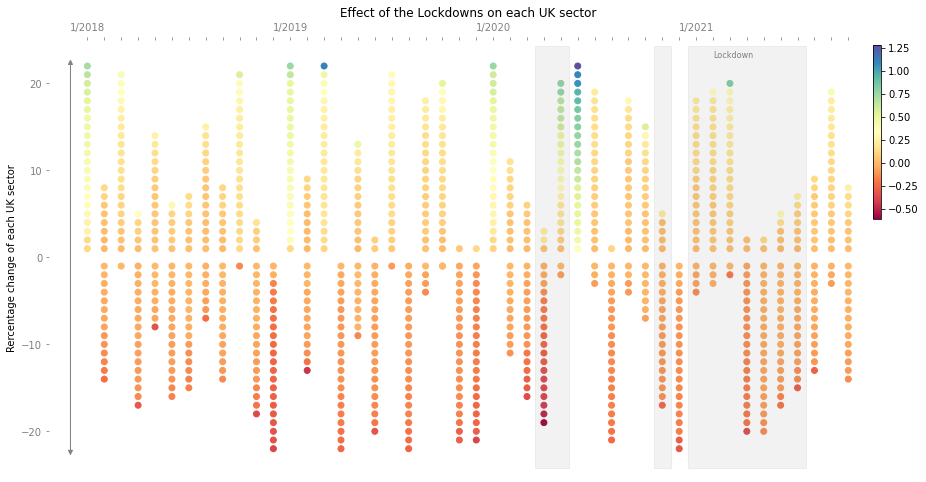

In [57]:
# Initialize the figure and the subplot
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)

# Creating the list of x and y values for the plot
x = data2['X_Axis'].to_list() 
y = data2['Position'].to_list()
cat=data2['Sector_1'].to_list()

# Populating the graph
im = ax.scatter(x,y, c=data2['Percentage_Change'].values, cmap='Spectral',)

ax.set_ylim(-25,25)
ax.set_ylabel('Rercentage change of each UK sector')

# Setting the periods with the lockdowns
ax.set_xticklabels(range(46))
ax.axvspan(xmin=35.5, xmax=42.5, ymin=0.015, ymax=0.985, color='grey',alpha=0.1, edgecolor='white')
ax.axvspan(xmin=33.5, xmax=34.5, ymin=0.015, ymax=0.985, color='grey',alpha=0.1, edgecolor='white')
ax.axvspan(xmin=26.5, xmax=28.5, ymin=0.015, ymax=0.985, color='grey',alpha=0.1, edgecolor='white')

ax.annotate('Lockdown', xy=(37,23) ,size = 8 , color='grey')

#ax.set_xticklabels(data_total['X_Axis'].unique())

axins = inset_axes(ax, width="1%", height="40%")
cb = fig.colorbar(im, cax=axins, shrink=1)
#cb.solids_patches

# Remove the spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.annotate("", xy=(-1, -23), xytext=(-1, 23), color='grey' , arrowprops=dict(arrowstyle='<|-|>',fc="grey", ec="grey"))

# Ticks Aesthetics
ax.xaxis.tick_top()
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')

ax.tick_params(color="grey")

every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
            
ax.set_xticklabels(data2['X_Axis'].unique())

ax.set_title('Effect of the Lockdowns on each UK sector')

plt.show()

# Third Graph

In [ ]:
UKdata3 = UKdata1.copy()

A csv which contains a full list of UK post codes was downloaded in order to group the company's data into distinct areas using the information of column 'ITL level 2'. The dataset can be found in the link bellow.

Source: https://www.doogal.co.uk/PostcodeDownloads.php?fbclid=IwAR1tTv3wa21lWXPTOh9ToppN2f6-Dl9nzIihIPqa1hNRi8RhJdIE2_Q2j8o

In [ ]:
# Importing the dataframe containg the postal codes and the areas coresponding to them
post = pd.read_csv('postcodes.csv')

In [ ]:
post['ITL level 2'].unique()

In [ ]:
# Creating a new column with post codes
UKdata3.loc[:, 'Postcode'] =UKdata3['RegAddress.PostCode']

In [ ]:
# Merge the dataframes using the post codes
cities = pd.merge(UKdata3, post, on ='Postcode', how ='inner')
cities

In [ ]:
# Createing data frame with necessary columns
city = cities[['CompanyName','Sector_1','CompanyCategory','CompanyStatus','RegAddress.County','RegAddress.PostCode','Postcode','Incorporation_New', 'Incorporation_Day', 'Incorporation_Month',
       'Incorporation_Year' ,'ITL level 2']]

In [ ]:
print(len(city['ITL level 2'].unique()))
city['ITL level 2'].unique()

In [ ]:
# Grouping some areas
city['ITL level 2'].replace({'North Eastern Scotland':'Scotland', 'Southern Scotland' :'Scotland',
                             'West Central Scotland' :'Scotland', 'Eastern Scotland' :'Scotland',
                             'East Wales':'Wales', 'West Wales and The Valleys' : 'Wales',
                            'East Yorkshire and Northern Lincolnshire' : 'Yorkshire',
                             'Inner London - West':'Inner London', 'Inner London - East' : 'Inner London',
                            'Outer London - West and North West': 'Outer London',
                             'Outer London - East and North East': 'Outer London', 'Outer London - South': 'Outer London',
                            'West Yorkshire':'Yorkshire', 'North Yorkshire': 'Yorkshire','South Yorkshire':'Yorkshire'},
                            inplace=True)

In [ ]:
# Ranking the areas with more new companies
print(city['ITL level 2'].value_counts())
city_top = city[(city['ITL level 2']=='Inner London')|(city['ITL level 2']=='Outer London')
                |(city['ITL level 2']=='Yorkshire') |(city['ITL level 2']=='Scotland')
               |(city['ITL level 2']=='Essex')|(city['ITL level 2']=='Greater Manchester')
               |(city['ITL level 2']=='Wales')|(city['ITL level 2']=='Northern Ireland')
               |(city['ITL level 2']=='Cheshire')|(city['ITL level 2']=='West Midlands')]

city_top.loc[:,'ITL_count'] = city['ITL level 2']

In [ ]:
# Counting the companies founded in each area
df4 = pd.DataFrame(city_top.groupby(['Incorporation_Year','Incorporation_Month','ITL level 2'], as_index=False)['ITL_count'].aggregate(np.count_nonzero))

In [ ]:
# Separating the data frame based on the lockdown periods
temp1 = df4.loc[(df4['Incorporation_Year']==2020) & ((df4['Incorporation_Month']==4)|(df4['Incorporation_Month']==5) |(df4['Incorporation_Month']==11))]
temp2 = df4.loc[(df4['Incorporation_Year']==2021) & ((df4['Incorporation_Month']==1)|(df4['Incorporation_Month']==2) |(df4['Incorporation_Month']==3)|
                                                     (df4['Incorporation_Month']==4)|(df4['Incorporation_Month']==5) |(df4['Incorporation_Month']==6)|
                                                     (df4['Incorporation_Month']==7))]
# Creating data frame of the Cities during lockdowns
cities_covid = pd.concat([temp1,temp2], axis=0)

In [ ]:
cities_covid = pd.DataFrame(cities_covid.groupby('ITL level 2',as_index=False)['ITL_count'].aggregate(np.sum))
cities_covid.loc[:,'Covid_Percentage'] = cities_covid['ITL_count'] / sum(cities_covid['ITL_count'].values)

In [ ]:
# Creating data frame of the cities for months without lockdowns
cities_norm = pd.concat([df4, cities_covid, cities_covid]).drop_duplicates(keep=False)
cities_norm = pd.DataFrame(cities_norm.groupby('ITL level 2',as_index=False)['ITL_count'].aggregate(np.sum))
cities_norm.loc[:,'Percentage'] = cities_norm['ITL_count'] / sum(cities_norm['ITL_count'].values)

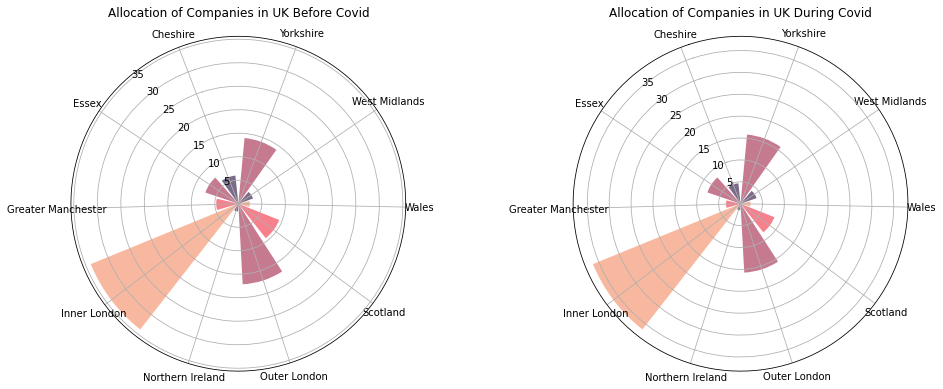

In [55]:
# Initialize layout in polar coordinates
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(1, 2, 1, polar=True)
ax1 = fig.add_subplot(1, 2, 2, polar=True)

ax.set_theta_offset(1.2 * np.pi / 2)
ax1.set_theta_offset(1.2 * np.pi / 2)
#ax.set_ylim(0, 40)

# Colors
COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195"]
# Colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

# Values for the x axis
angles = np.linspace(0.05, 2 * np.pi - 0.05, len(cities_covid['ITL_count']), endpoint=False)
# Percentages of companies percentages
companies = cities_covid['Covid_Percentage'].values*100
# Labels for the ticks
labels = cities_covid['ITL level 2'].values

# Values for the x axis
angles2 = np.linspace(0.05, 2 * np.pi - 0.05, len(cities_norm['ITL_count']), endpoint=False)
# Percentages of companies percentages
companies2 = cities_norm['Percentage'].values*100
# Labels for the ticks
labels2 = cities_norm['ITL level 2'].values


# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")
ax1.set_facecolor("white")


# Populating the graphs
ax.bar(angles2, companies2, color=COLORS, alpha=0.9, width=0.52)
ax1.bar(angles, companies, color=COLORS, alpha=0.9, width=0.52)

# Seting titles for the plots
ax.set_title('Allocation of Companies in UK Before Covid', pad=20)
ax1.set_title('Allocation of Companies in UK During Covid', pad=20)

# Setting the x labels 
ax.set_xticks(angles)
ax.set_xticklabels(labels)
ax1.set_xticks(angles2)
ax1.set_xticklabels(labels2)

# Creating separation of the plots
plt.subplots_adjust(wspace=0.5, hspace=0)

plt.show()